In [1]:
import pandas as pd
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X = pd.read_csv("dataset/X_data.csv")
y = pd.read_csv("dataset/y_data.csv").Status

In [3]:
numeric_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
                   'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
categorical_unordered_features = ["Drug", "Sex"]
categorical_ordered_features = ["Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [4]:
import pdb

class CustomKNNImputer(KNNImputer):
    def __init__(self, n_neighbors=5, weights="uniform", **kwargs):
        super().__init__(n_neighbors=n_neighbors, weights=weights, **kwargs)
        self.n_neighbors = n_neighbors
        self.weights = weights
        global y
        self.y = y.copy()
    
    def fit(self, X, *args, **kwargs):
        self.imputer_by_class_ = {}
        for cls in self.y.unique():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            self.imputer_by_class_[cls] = KNNImputer(n_neighbors=self.n_neighbors, weights=self.weights).fit(X.loc[indices])
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for cls, imputer in self.imputer_by_class_.items():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            X_transformed.loc[indices] = imputer.transform(X.loc[indices])
        return X_transformed

class CustomSimpleImputer(SimpleImputer):
    def __init__(self, strategy="most_frequent", **kwargs):
        super().__init__(strategy=strategy, **kwargs)
        self.strategy = strategy
        global y
        self.y = y.copy()
        
    def fit(self, X, *args, **kwargs):
        self.imputer_by_class_ = {}
        for cls in self.y.unique():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            self.imputer_by_class_[cls] = SimpleImputer(strategy=self.strategy).fit(X.loc[indices])
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        for cls, imputer in self.imputer_by_class_.items():
            indices = self.y[self.y.index.isin(X.index) & (self.y == cls)].index
            X_transformed.loc[indices] = imputer.transform(X.loc[indices])
        return X_transformed

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, custom_orders):
        self.custom_orders = custom_orders
        self.encoders = {}

    def fit(self, X, y=None):
        for col, categories in self.custom_orders.items():
            encoder = OrdinalEncoder(categories=[categories], handle_unknown='use_encoded_value', unknown_value=-1)
            encoder.fit(X[[col]])
            self.encoders[col] = encoder
        return self

    def transform(self, X):
        for col, encoder in self.encoders.items():
            X[col] = encoder.transform(X[[col]])
        return X
        
custom_orders = {
    'Ascites': ['N', 'Y'],
    'Hepatomegaly': ['N', 'Y'],
    'Spiders': ['N', 'Y'],
    'Edema': ['N', 'S', 'Y'],
    'Stage': ['1.0', '2.0', '3.0', '4.0']
}

In [6]:
from imblearn.base import BaseSampler
from collections import Counter

class ENNBSmoteBalancer(BaseSampler):
    def __init__(self, k_neighbors_cleaning=5, k_neighbors_borders=5):
        self.k_neighbors_cleaning = k_neighbors_cleaning
        self.k_neighbors_borders = k_neighbors_borders

    def _fit_resample(self, X, y):
        return self.fit_resample(X, y)
        
    def fit_resample(self, X, y):
        ncl = EditedNearestNeighbours(sampling_strategy=["High chance"], n_neighbors=self.k_neighbors_cleaning)
        X_resampled, y_resampled = ncl.fit_resample(X, y)
        
        borsmote = BorderlineSMOTE(random_state=0, k_neighbors=self.k_neighbors_borders)
        X_resampled, y_resampled = borsmote.fit_resample(X_resampled, y_resampled)
        
        return X_resampled, y_resampled

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", CustomKNNImputer()),
            ("scaler", RobustScaler())
        ]), numeric_features),
        ("cat_unord", Pipeline([
            ("imputer", CustomSimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder())
        ]), categorical_unordered_features),
        ("cat_ord", Pipeline([
            ("imputer", CustomSimpleImputer(strategy="most_frequent")),
            ("encoder", CustomOrdinalEncoder(custom_orders))
        ]), categorical_ordered_features)
    ]
)

In [8]:
clf_RandomForest = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", SelectKBest()),
        ('sampler', ENNBSmoteBalancer()),
        ("classifier", RandomForestClassifier(random_state=0, n_jobs=-1))
    ]
)
clf_KNNeighbor = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", SelectKBest()),
        ('sampler', ENNBSmoteBalancer()),
        ("classifier", KNeighborsClassifier(n_jobs=-1))
    ]
)
clf_AdaBoostGNB = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", SelectKBest()),
        ('sampler', ENNBSmoteBalancer()),
        ("classifier", AdaBoostClassifier(random_state=0, estimator=GaussianNB(), algorithm="SAMME"))
    ]
)
clf_LogReg = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selector", SelectKBest()),
        ('sampler', ENNBSmoteBalancer()),
        ("classifier", LogisticRegression(random_state=0))
    ]
)

clf_RandomForest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomKNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['N_Days', 'Age', 'Bilirubin',
                                                   'Cholesterol', 'Albumin',
                                                   'Copper', 'Alk_Phos', 'SGOT',
                                                   'Tryglicerides', 'Platelets',
                                                   'Prothrombin']),
                                                 ('cat_unord',
                                                  Pipeline(steps=[('imputer',
                                                                   CustomSimpleImputer()),
                                                                  ('encoder',
                                                                   OneHotE...
                                                                   CustomOrdinalEncoder(custom_orders={'Ascites': ['N',
                                                                                                                   'Y'],
                                                                                                       'Edema': ['N',
                                                                                                                 'S',
                                                                                                                 'Y'],
                                                                                                       'Hepatomegaly': ['N',
                                                                                                                        'Y'],
                                                                                                       'Spiders': ['N',
                                                                                                                   'Y'],
                                                                                                       'Stage': ['1.0',
                                                                                                                 '2.0',
                                                                                                                 '3.0',
                                                                                                                 '4.0']}))]),
                                                  ['Ascites', 'Hepatomegaly',
                                                   'Spiders', 'Edema',
                                                   'Stage'])])),
                ('feature_selector', SelectKBest()),
                ('sampler', ENNBSmoteBalancer()),
                ('classifier',
                 RandomForestClassifier(n_jobs=-1, random_state=0))])

In [9]:
# Parametri per RandomForest
param_grid_RandomForest = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),
    
    "feature_selector__k": range(1, 21),
    
    "sampler__k_neighbors_cleaning": range(3, 10, 2),
    "sampler__k_neighbors_borders": range(3, 10, 2),
    
    "classifier__max_depth": range(2, 8),
    "classifier__criterion": ["gini", "entropy"],
}

# Parametri per KNNeighbor
param_grid_KNNeighbor = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),
    
    "feature_selector__k": range(1, 21),
    
    "sampler__k_neighbors_cleaning": range(3, 10, 2),
    "sampler__k_neighbors_borders": range(3, 10, 2),
    
    "classifier__n_neighbors": range(3, 18, 2),
}

# Parametri per AdaBoostGNB
param_grid_AdaBoostGNB = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),
    
    "feature_selector__k": range(1, 21),
    
    "sampler__k_neighbors_cleaning": range(3, 10, 2),
    "sampler__k_neighbors_borders": range(3, 10, 2),
    
    "classifier__learning_rate": [0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5],
}

# Parametri per LogReg
param_grid_LogReg = {
    "preprocessor__num__imputer__n_neighbors": range(3, 16),
    
    "feature_selector__k": range(1, 21),
    
    "sampler__k_neighbors_cleaning": range(2, 9, 2),
    "sampler__k_neighbors_borders": range(2, 9, 2),
    
    "classifier__C": [0.01, 0.1, 1, 10, 100],
}

In [10]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
inner_skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
outer_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
scorer = "f1_weighted"

Migliori parametri Random Forest: {'sampler__k_neighbors_cleaning': 5, 'sampler__k_neighbors_borders': 5, 'preprocessor__num__imputer__n_neighbors': 13, 'feature_selector__k': 20, 'classifier__max_depth': 6, 'classifier__criterion': 'gini'}
                   precision    recall  f1-score   support

      High chance       0.94      0.74      0.83        23
       Low chance       0.75      0.88      0.81        17
Transplant needed       0.50      1.00      0.67         2

         accuracy                           0.81        42
        macro avg       0.73      0.87      0.77        42
     weighted avg       0.84      0.81      0.81        42

                   precision    recall  f1-score   support

      High chance       0.95      0.79      0.86        24
       Low chance       0.83      0.94      0.88        16
Transplant needed       0.50      1.00      0.67         2

         accuracy                           0.86        42
        macro avg       0.76      0.91      0.

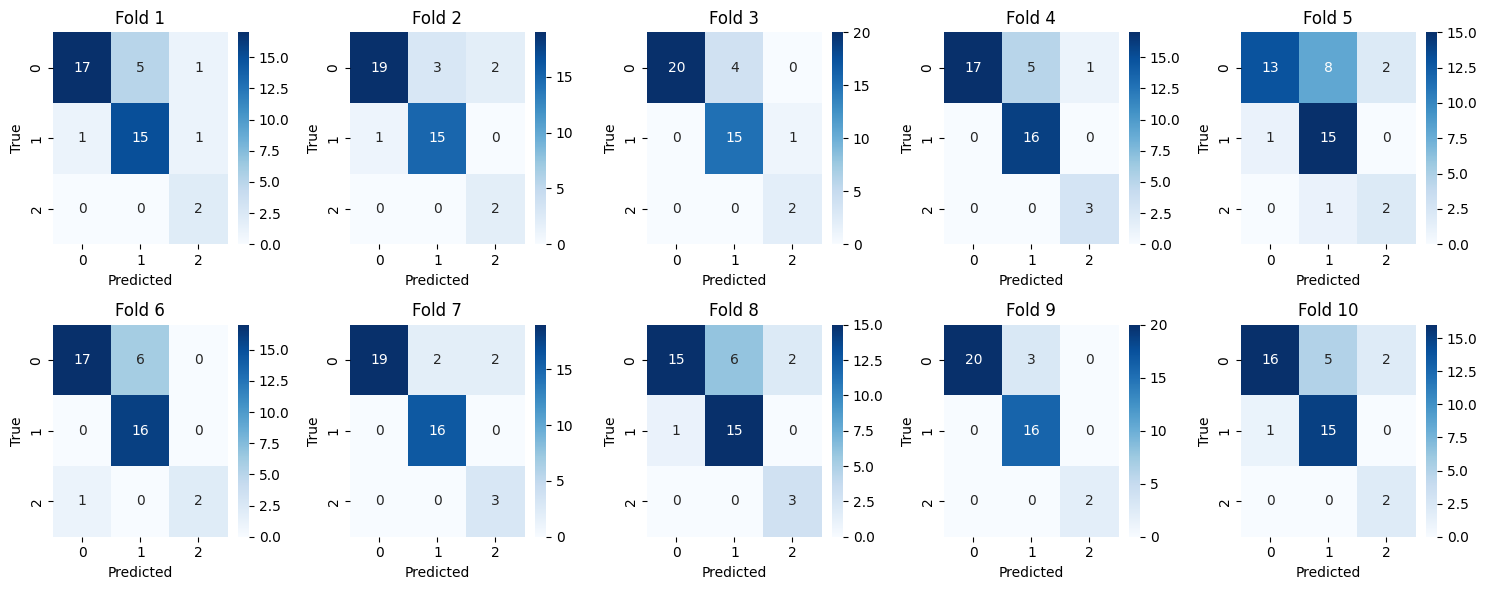

In [11]:
clfrf = RandomizedSearchCV(
    estimator = clf_RandomForest, 
    param_distributions=param_grid_RandomForest,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfrf.fit(X, y)

best_params = clfrf.best_params_
print("Migliori parametri Random Forest:", best_params)

f_weighted_scores1 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfrf.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_weighted_scores1.append(report["weighted avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

Migliori parametri Random Forest: {'sampler__k_neighbors_cleaning': 7, 'sampler__k_neighbors_borders': 9, 'preprocessor__num__imputer__n_neighbors': 10, 'feature_selector__k': 9, 'classifier__n_neighbors': 11}
                   precision    recall  f1-score   support

      High chance       0.85      0.48      0.61        23
       Low chance       0.62      0.59      0.61        17
Transplant needed       0.15      1.00      0.27         2

         accuracy                           0.55        42
        macro avg       0.54      0.69      0.49        42
     weighted avg       0.72      0.55      0.59        42

                   precision    recall  f1-score   support

      High chance       0.84      0.67      0.74        24
       Low chance       0.79      0.69      0.73        16
Transplant needed       0.11      0.50      0.18         2

         accuracy                           0.67        42
        macro avg       0.58      0.62      0.55        42
     weighted avg 

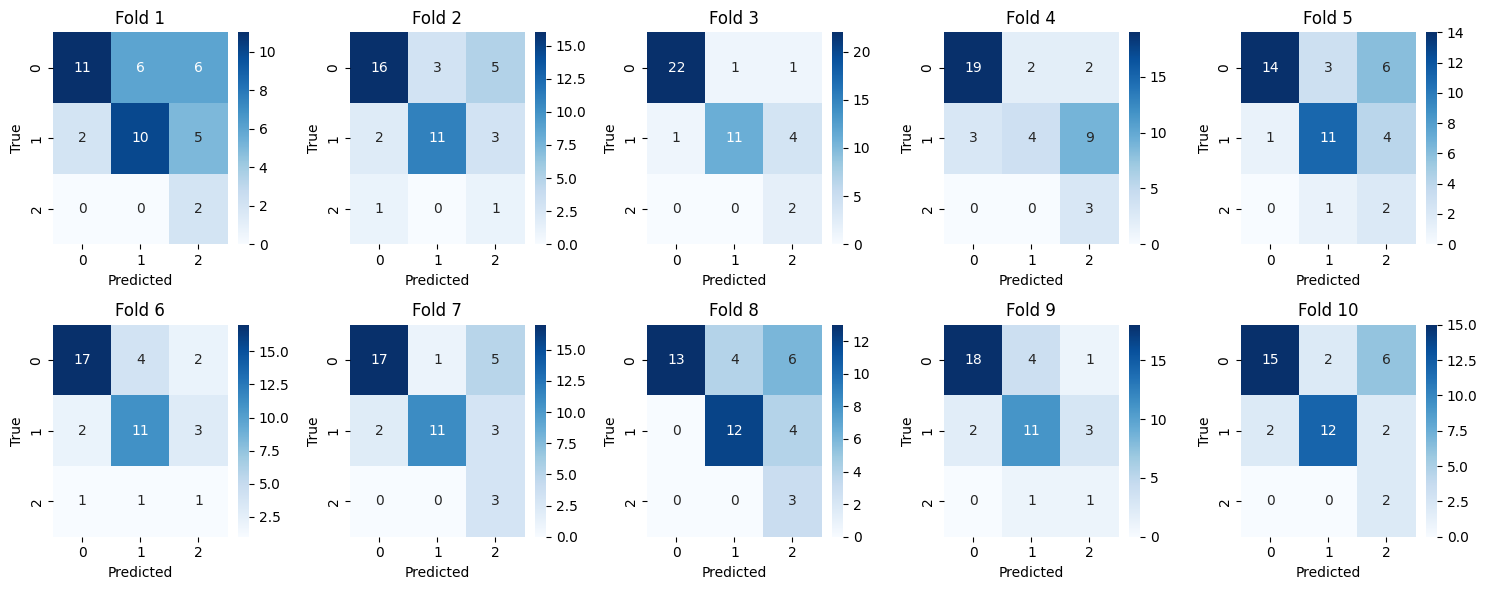

In [12]:
clfknn = RandomizedSearchCV(
    estimator = clf_KNNeighbor, 
    param_distributions=param_grid_KNNeighbor,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfknn.fit(X, y)

best_params = clfknn.best_params_
print("Migliori parametri Random Forest:", best_params)

f_weighted_scores2 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfknn.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_weighted_scores2.append(report["weighted avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

Migliori parametri Random Forest: {'sampler__k_neighbors_cleaning': 3, 'sampler__k_neighbors_borders': 3, 'preprocessor__num__imputer__n_neighbors': 8, 'feature_selector__k': 5, 'classifier__learning_rate': 0.9}
                   precision    recall  f1-score   support

      High chance       0.81      0.74      0.77        23
       Low chance       0.67      0.35      0.46        17
Transplant needed       0.17      1.00      0.29         2

         accuracy                           0.60        42
        macro avg       0.55      0.70      0.51        42
     weighted avg       0.72      0.60      0.62        42

                   precision    recall  f1-score   support

      High chance       0.83      0.79      0.81        24
       Low chance       0.78      0.44      0.56        16
Transplant needed       0.20      1.00      0.33         2

         accuracy                           0.67        42
        macro avg       0.60      0.74      0.57        42
     weighted av

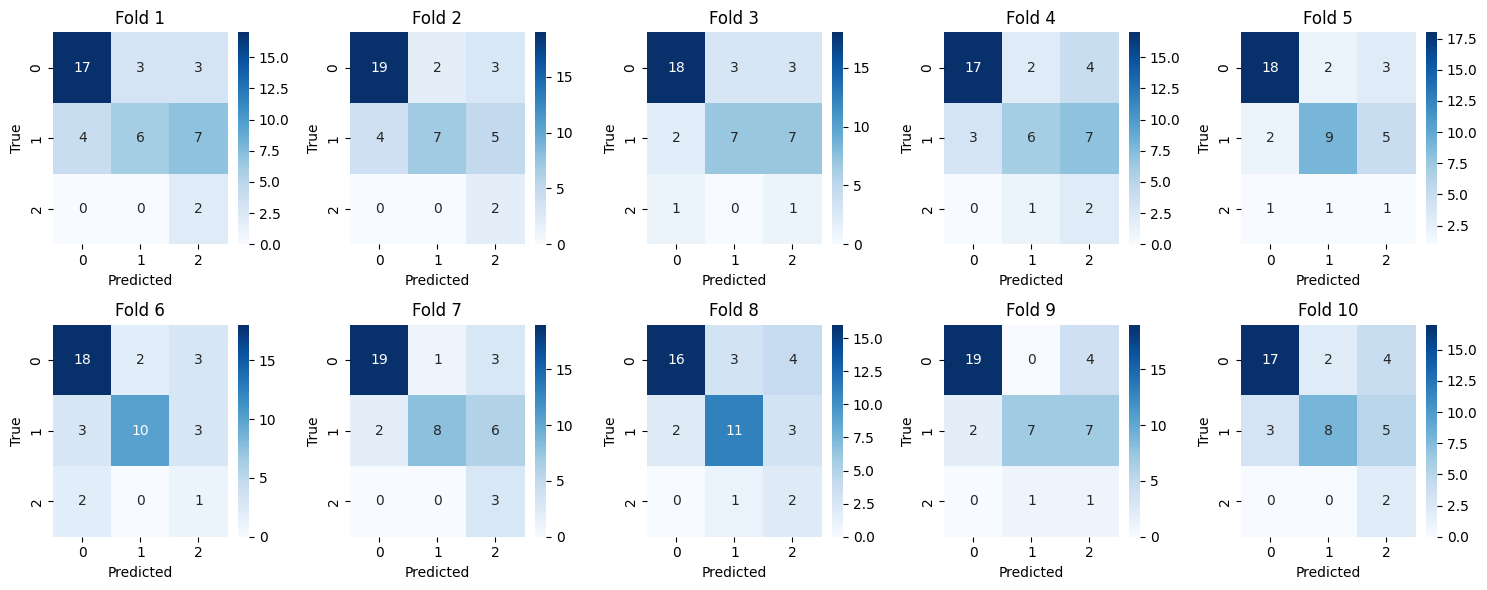

In [13]:
clfadagnb = RandomizedSearchCV(
    estimator = clf_AdaBoostGNB, 
    param_distributions=param_grid_AdaBoostGNB,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clfadagnb.fit(X, y)

best_params = clfadagnb.best_params_
print("Migliori parametri Random Forest:", best_params)

f_weighted_scores3 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clfadagnb.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_weighted_scores3.append(report["weighted avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

Migliori parametri Random Forest: {'sampler__k_neighbors_cleaning': 2, 'sampler__k_neighbors_borders': 2, 'preprocessor__num__imputer__n_neighbors': 9, 'feature_selector__k': 15, 'classifier__C': 100}
                   precision    recall  f1-score   support

      High chance       0.95      0.78      0.86        23
       Low chance       0.73      0.65      0.69        17
Transplant needed       0.25      1.00      0.40         2

         accuracy                           0.74        42
        macro avg       0.64      0.81      0.65        42
     weighted avg       0.83      0.74      0.77        42

                   precision    recall  f1-score   support

      High chance       0.78      0.75      0.77        24
       Low chance       0.85      0.69      0.76        16
Transplant needed       0.17      0.50      0.25         2

         accuracy                           0.71        42
        macro avg       0.60      0.65      0.59        42
     weighted avg       0.7

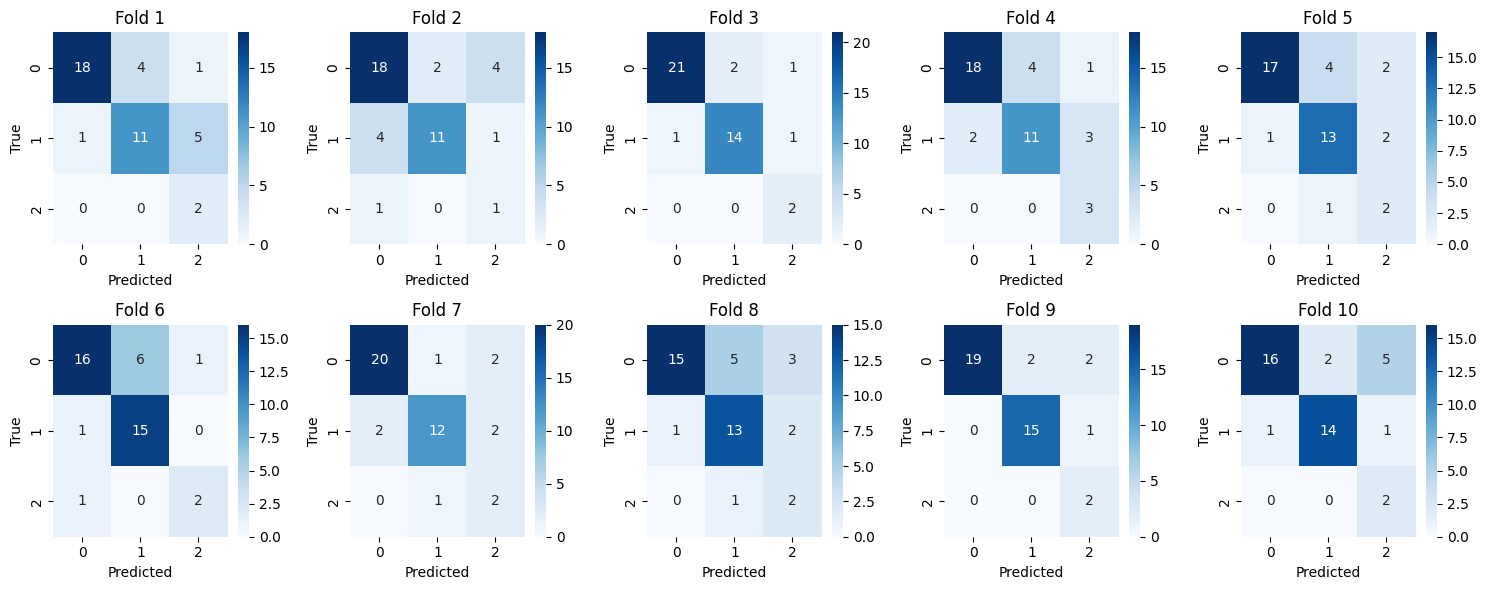

In [14]:
clflr = RandomizedSearchCV(
    estimator = clf_LogReg, 
    param_distributions=param_grid_LogReg,
    cv = skf,
    scoring = scorer,
    n_jobs=-1,
    random_state=0,
    n_iter=20,
)
clflr.fit(X, y)

best_params = clflr.best_params_
print("Migliori parametri Random Forest:", best_params)

f_weighted_scores4 = []
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_fold_train, X_fold_valid = X.iloc[train_index], X.iloc[test_index]
    y_fold_train, y_fold_valid = y.iloc[train_index], y.iloc[test_index]

    y_pred = clflr.predict(X_fold_valid)

    cm = confusion_matrix(y_fold_valid, y_pred)
    report = classification_report(y_fold_valid, y_pred, output_dict=False)
    print(report)
    report = classification_report(y_fold_valid, y_pred, output_dict=True)
    f_weighted_scores4.append(report["weighted avg"]["f1-score"])

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[fold // 5, fold % 5])
    axes[fold // 5, fold % 5].set_title(f'Fold {fold+1}')
    axes[fold // 5, fold % 5].set_xlabel('Predicted')
    axes[fold // 5, fold % 5].set_ylabel('True')

plt.tight_layout()
plt.show()

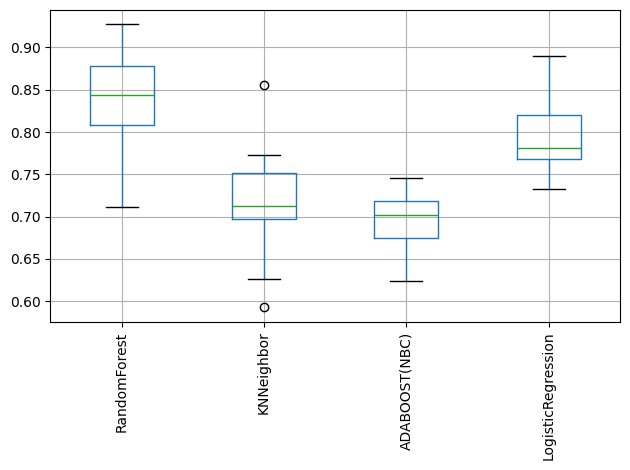

In [15]:
cv_scores = {
    'RandomForest': f_weighted_scores1,
    'KNNeighbor': f_weighted_scores2,
    'ADABOOST(NBC)': f_weighted_scores3,
    'LogisticRegression': f_weighted_scores4
}

df_cv_scores = pd.DataFrame(cv_scores)

df_cv_scores.boxplot()
plt.xticks(ticks=range(1, len(df_cv_scores.columns) + 1), labels=df_cv_scores.columns, rotation=90)
plt.tight_layout()
plt.savefig("stat_resultKB.png")
plt.show()

In [16]:
from scipy.stats import kruskal
from itertools import combinations
from scipy.stats import wilcoxon

kruskal_result = kruskal(cv_scores["RandomForest"], 
                         cv_scores["KNNeighbor"], 
                         cv_scores["ADABOOST(NBC)"], 
                         cv_scores["LogisticRegression"])

print("Kruskal-Wallis statistic:", kruskal_result.statistic)
print("p value:", kruskal_result.pvalue)

if kruskal_result.pvalue < 0.05:
    print("There is a statistically relevant difference between at least two groups.")
    models = ["RandomForest", "KNNeighbor", "ADABOOST(NBC)", "LogisticRegression"]
    couples = list(combinations(models, 2))
    
    for _ in couples:
        m1, m2 = _
        wilcoxon_result = wilcoxon(cv_scores[m1], cv_scores[m2])
        
        print("Comparing", m1, "and", m2)
        print("Wilcoxon statistic:", wilcoxon_result.statistic)
        print("p value:", wilcoxon_result.pvalue)
        
        if wilcoxon_result.pvalue < 0.05:
            print("There is a statistically relevant difference between", m1, "and", m2)
        else:
            print("There is no statistically relevant difference between", m1, "and", m2)
        print("----")
else:
    print("There are no statistically relevant difference between groups.")

Kruskal-Wallis statistic: 22.379999999999995
p value: 5.437016948003457e-05
There is a statistically relevant difference between at least two groups.
Comparing RandomForest and KNNeighbor
Wilcoxon statistic: 0.0
p value: 0.001953125
There is a statistically relevant difference between RandomForest and KNNeighbor
----
Comparing RandomForest and ADABOOST(NBC)
Wilcoxon statistic: 0.0
p value: 0.001953125
There is a statistically relevant difference between RandomForest and ADABOOST(NBC)
----
Comparing RandomForest and LogisticRegression
Wilcoxon statistic: 10.0
p value: 0.083984375
There is no statistically relevant difference between RandomForest and LogisticRegression
----
Comparing KNNeighbor and ADABOOST(NBC)
Wilcoxon statistic: 17.0
p value: 0.322265625
There is no statistically relevant difference between KNNeighbor and ADABOOST(NBC)
----
Comparing KNNeighbor and LogisticRegression
Wilcoxon statistic: 0.0
p value: 0.001953125
There is a statistically relevant difference between KNNe